# Identify cause of 500-800 m iceshelf cavity cold plume (convection?)

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as cl
import cmocean
import cartopy.crs as ccrs
import tqdm
import cartopy.feature as cfeature
import glob
import sys
sys.path.append('/home/users/birgal/')

from nemo_python_git.file_io   import read_dutrieux
from nemo_python_git.grid      import transect_coords_from_latlon_waypoints, connect_coord_points
from nemo_python_git.constants import transect_amundsen, land_colour, iceshelf_colour
from nemo_python_git.plots import finished_plot

In [2]:
base_dir = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/'
run_folder    = f'{base_dir}output/ERA5_test4_cont/'
nemo_mesh     = f'{base_dir}bathymetry/mesh_mask-20240305.nc'
nemo_domain   = f'{base_dir}bathymetry/domain_cfg-20240305.nc'

In [3]:
nemo_mesh_ds  = xr.open_dataset(nemo_mesh).isel(time_counter=0)
nemo_mesh_sub = nemo_mesh_ds #.isel(x=slice(500, 880), y=slice(150,300))

bathy = xr.where((nemo_mesh_sub.isfdraft > 0) | (nemo_mesh_sub.bathy_metry==0), np.nan, nemo_mesh_sub.bathy_metry)

### Test: change thickness of ice shelf top boundary layer (from 20 m to 5 m)

In [10]:
folder20 = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/output/ERA5_test5/new_ICs_w_icb_rn_htbl_20/'
folder5  = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/output/ERA5_test5/new_ICs_w_icb_rn_htbl_5/'

# files20  = glob.glob(f'{folder20}eANT025.L121_1d_19790101_19791231_grid_T_1979*')
# ds20     = xr.open_mfdataset(files20).isel(time_counter=slice(0,100)) 
# ds20     = ds20.rename({'x_grid_T':'x', 'y_grid_T':'y'}).isel(x=slice(600, 760), y=slice(200,250))
# Tcold20  = xr.where(ds20.thetao.isel(deptht=57) < 0.2, ds20.thetao.isel(deptht=57), np.nan)
# land     = xr.where(ds20.thetao.isel(deptht=57) == 0.0, 1, np.nan)

files5   = glob.glob(f'{folder5}eANT025.L121_1d_19790101_19791231_grid_T_1979*')
ds5      = xr.open_mfdataset(files5).isel(time_counter=slice(0,100)) 
ds5      = ds5.rename({'x_grid_T':'x', 'y_grid_T':'y'}).isel(x=slice(600, 760), y=slice(200,250))
Tcold5   = xr.where(ds5.thetao.isel(deptht=57) < 0.2, ds5.thetao.isel(deptht=57), np.nan)
land     = xr.where(ds5.thetao.isel(deptht=57) == 0.0, 1, np.nan)

In [12]:
# nemo_ds20 = ds20.rename({'so':'AbsSal','thetao':'ConsTemp'})
# N2_20     = stratification(nemo_ds20)
# sigma_20  = gsw.density.sigma0(nemo_ds20.AbsSal, nemo_ds20.ConsTemp)
nemo_ds5 = ds5.rename({'so':'AbsSal','thetao':'ConsTemp'})
N2_5     = stratification(nemo_ds5)
sigma_5  = gsw.density.sigma0(nemo_ds5.AbsSal, nemo_ds5.ConsTemp)

/home/users/birgal/.conda/envs/jaspy3.10/lib/python3.10/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


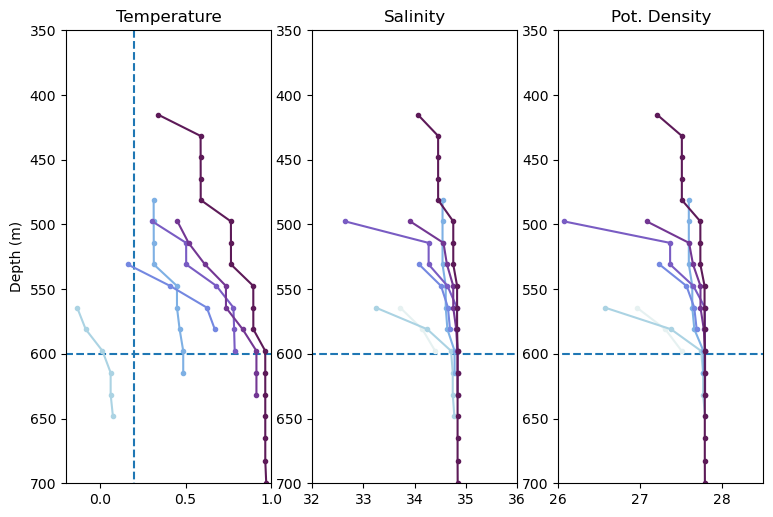

In [13]:
ax = setup_axes(zmin=700, zmax=350)

xvals = range(63,70)
for n, i in enumerate(xvals):
    ax = plot_profiles(ax, nemo_ds5, sigma_5, N2_5, tstep=15, xind=i, yind=29, color=cmocean.cm.dense(n/len(xvals)))

### Identify locations where there is definitely a problem temperature

In [4]:
folder1d='/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/output/ERA5_test5/new_ICs_n_icb/'
files = glob.glob(f'{folder1d}files/eANT025.L121_1d_19790101_19791231_grid_T_1979*')
ds    = xr.open_mfdataset(files).isel(time_counter=slice(0,100)) 
ds    = ds.rename({'x_grid_T':'x', 'y_grid_T':'y'}).isel(x=slice(600, 760), y=slice(200,250))

In [5]:
Tcold = xr.where(ds.thetao.isel(deptht=57) < 0.2, ds.thetao.isel(deptht=57), np.nan)
land  = xr.where(ds.thetao.isel(deptht=57) == 0.0, 1, np.nan)

Text(0.5, 1.0, 'y1979m01d16')

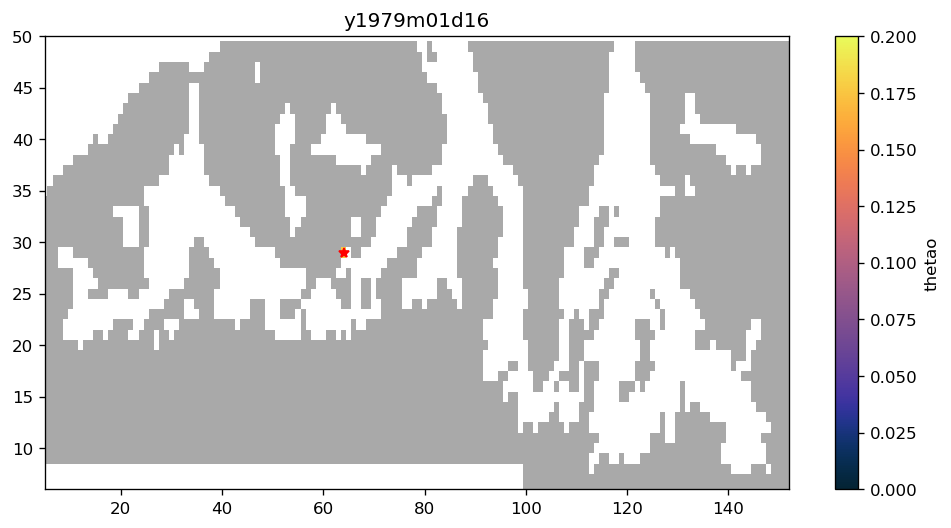

In [10]:
num = 15
    
fig, ax = plt.subplots(1,1, figsize=(10,5), dpi=120)
Tcold.isel(time_counter=num).plot(ax=ax, cmap=cmocean.cm.thermal, vmax=0.2)
land.isel(time_counter=num).plot(ax=ax, cmap=cl.ListedColormap(['DarkGrey']), add_colorbar=False)
ax.plot([64],[29],'*r')
ax.set_xlim(5, 152)
ax.set_ylim(6, 50)
ax.set_xlabel('')
ax.set_ylabel('')
date = Tcold.isel(time_counter=num).time_counter.dt.strftime('y%Ym%md%d').values
ax.set_title(date)

Now that I've identified problem cells, plot profiles of properties at these cells

(also draw a transect of observations with trange 0.2-1.0

In [4]:
import gsw
from nemo_python_git.constants import deg2rad, gravity, omegaEarth

In [11]:
nemo_ds = ds.rename({'so':'AbsSal','thetao':'ConsTemp'})
N2      = stratification(nemo_ds)
sigma   = gsw.density.sigma0(nemo_ds.AbsSal, nemo_ds.ConsTemp)

/home/users/birgal/.conda/envs/jaspy3.10/lib/python3.10/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [11]:
def plot_profiles(ax, nemo_ds, sigma, N2, tstep=0, xind=64, yind=29, color='k'):

    profile_ds    = nemo_ds.isel(time_counter=tstep,x=xind,y=yind)
    profile_sigma = sigma.isel(time_counter=tstep,x=xind,y=yind)
    profile_N2    = N2.isel(time_counter=tstep,x=xind,y=yind)
    depths        = xr.where(profile_ds.AbsSal==0, np.nan, profile_ds.deptht_bounds.mean(dim='axis_nbounds'))
    
    kwags={'marker':'.', 'color':color}
    ax[0].plot(profile_ds.ConsTemp, depths, **kwags)
    ax[1].plot(profile_ds.AbsSal, depths, **kwags)
    ax[2].plot(profile_sigma, depths, **kwags)
    # ax[3].plot(profile_N2, depths.values[:-1], **kwags)
    # ax[3].set_xlim(-2e-3, 0)

    return ax

In [7]:
def setup_axes(zmin=700, zmax=0):
    fig, ax = plt.subplots(1,3, figsize=(9,6), dpi=100)

    ax[0].set_xlim(-0.2, 1)
    ax[1].set_xlim(32, 36)
    ax[2].set_xlim(26, 28.5)

    ax[0].set_ylabel('Depth (m)')
    ax[0].vlines(ymax=zmin, ymin=zmax, x=0.2, linestyle='--')
    titles=['Temperature','Salinity','Pot. Density','N-squared']
    for n, axis in enumerate(ax.ravel()):
        axis.set_ylim(zmin, zmax)
        axis.set_title(titles[n])
        axis.hlines(y=600, xmin=-100, xmax=100, linestyle='--')
    
    return ax

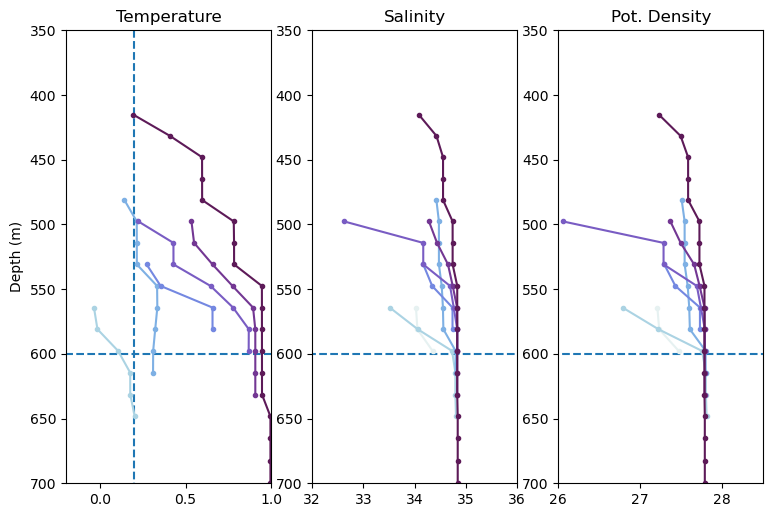

In [31]:
ax = setup_axes(zmin=700, zmax=350)

xvals = range(63,70)
for n, i in enumerate(xvals):
    ax = plot_profiles(ax, tstep=15, xind=i, yind=29, color=cmocean.cm.dense(n/len(xvals)))

Text(0.5, 1.0, 'y1979m01d16')

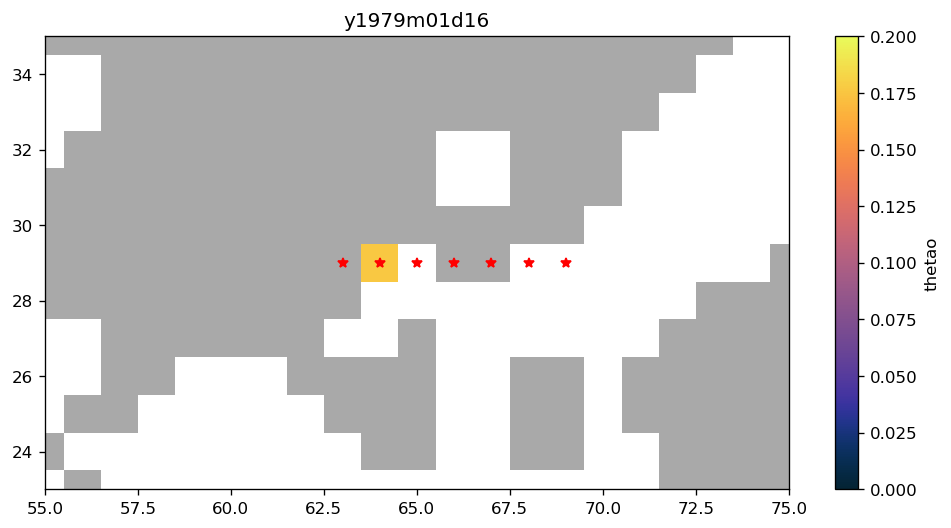

In [20]:
num = 15
    
fig, ax = plt.subplots(1,1, figsize=(10,5), dpi=120)
Tcold.isel(time_counter=num).plot(ax=ax, cmap=cmocean.cm.thermal, vmax=0.2)
land.isel(time_counter=num).plot(ax=ax, cmap=cl.ListedColormap(['DarkGrey']), add_colorbar=False)
ax.plot(np.arange(63,70), 29*np.ones(np.arange(63,70).shape),'*r')
ax.set_xlim(55, 75)
ax.set_ylim(23, 35)
ax.set_xlabel('')
ax.set_ylabel('')
date = Tcold.isel(time_counter=num).time_counter.dt.strftime('y%Ym%md%d').values
ax.set_title(date)

In [5]:
# Calculate stratification (Brünt-Väisälä Frequency, N squared) as:
# N^2 = (-g / sigma) * (d_sigma / dz)
# Inputs:
# nemo_ds : xarray dataset containing absolute salinity ('AbsSal'), conservative temperature ('ConsTemp'), and 
# Returns: xarray dataarray of stratification values
def stratification(nemo_ds):
    import gsw

    # calculate potential density:
    sigma  = gsw.density.sigma0(nemo_ds.AbsSal, nemo_ds.ConsTemp)
    # calculate simple vertical gradients:
    dsigma = sigma.diff('deptht')
    dz     = nemo_ds.e3t
    # calculate N2
    Nsquared  = (-gravity/sigma)*(dsigma/dz)

    return Nsquared

# Function to calculate the Coriolis frequency (in radians)
# Inputs:
# lat : latitude (in degrees)
# Returns: Coriolis parameter at specified latitude (in the same format as the supplied latitude)
def coriolis_freq(lat):
    
    theta = lat*deg2rad # convert latitude from degrees to radians
    f = 2*omegaEarth*np.sin(theta)

    return f

# Calculate Potential Vorticity from: 
# q = f * N^2/ g
# pot_vorticity = -(coriolis_freq(lat)/sigma) * (dsigma/dz)

### Look at transect coming off the shelf


In [29]:
gridT_files  = glob.glob(f'{run_folder}/*grid_T*')
nemo_ds      = xr.open_dataset(gridT_files[0])
# nemo_ds      = xr.open_mfdataset(gridT_files, engine='netcdf4', chunks={'x_grid_T':400, 'y_grid_T':200, 'deptht':10)
nemo_ds      = nemo_ds.rename({'x_grid_T':'x', 'y_grid_T':'y', 'nav_lon_grid_T':'nav_lon', 'nav_lat_grid_T':'nav_lat', 'deptht':'depth'}) 

In [5]:
def plot_land(nemo_mesh, file_var, depth_lev=0):
    lon_plot = np.ma.masked_where(nemo_mesh.tmask.isel(nav_lev=depth_lev) != 0, nemo_mesh.nav_lon.values)
    lat_plot = np.ma.masked_where(nemo_mesh.tmask.isel(nav_lev=depth_lev) != 0, nemo_mesh.nav_lat.values)
    plot_var = np.ma.masked_where(nemo_mesh.tmask.isel(nav_lev=depth_lev) != 0, file_var.values)
    return lon_plot, lat_plot, plot_var 

In [6]:
obs          = read_dutrieux(eos='teos10')
dutrieux_obs = obs.assign({'nav_lon':obs.lon, 'nav_lat':obs.lat}).rename_dims({'lat':'y', 'lon':'x'})
x_obs, y_obs      = transect_coords_from_latlon_waypoints(dutrieux_obs, transect_amundsen['shelf_west'], opt_float=False)    
obs_transect_west = dutrieux_obs.isel(x=xr.DataArray(x_obs, dims='n'), y=xr.DataArray(y_obs, dims='n'))
x_obs, y_obs      = transect_coords_from_latlon_waypoints(dutrieux_obs, transect_amundsen['shelf_mid'], opt_float=False)    
obs_transect_mid  = dutrieux_obs.isel(x=xr.DataArray(x_obs, dims='n'), y=xr.DataArray(y_obs, dims='n'))
x_obs, y_obs      = transect_coords_from_latlon_waypoints(dutrieux_obs, transect_amundsen['shelf_east'], opt_float=False)    
obs_transect_east = dutrieux_obs.isel(x=xr.DataArray(x_obs, dims='n'), y=xr.DataArray(y_obs, dims='n'))

In [33]:
def plot_Amundsen_2d_slices(nemo_ds, var_name='thetao', vlim=(-1.5, 0.5), savefig=False, figname=''):

    fig, ax = plt.subplots(3,3, figsize=(12,10), subplot_kw={'projection': ccrs.Mercator(latitude_true_scale=-70)}, dpi=150)

    # add a line to mark location of shelf west transect
    obs               = read_dutrieux(eos='teos10')
    dutrieux_obs      = obs.assign({'nav_lon':obs.lon, 'nav_lat':obs.lat}).rename_dims({'lat':'y', 'lon':'x'})
    x_obs, y_obs      = transect_coords_from_latlon_waypoints(dutrieux_obs, transect_amundsen['shelf_west'], opt_float=False)    
    obs_transect_west = dutrieux_obs.isel(x=xr.DataArray(x_obs, dims='n'), y=xr.DataArray(y_obs, dims='n'))

    # plot each depth slice
    depthind = [30,35,40,45,50,55,60,65,68]
    for n, axis in enumerate(ax.ravel()):
        axis.set_extent([-95, -125, -75.5, -70], ccrs.PlateCarree())
        gl = axis.gridlines(draw_labels=True);
        gl.xlines=None; gl.ylines=None; gl.top_labels=None; gl.right_labels=None;

        var_plot = np.ma.masked_where(nemo_ds[var_name].isel(depth=depthind[n]).values == 0, 
                                      nemo_ds[var_name]isel(depth=depthind[n]).values)
        img1 = axis.pcolormesh(nemo_ds.nav_lon.values, nemo_ds.nav_lat.values, 
                               var_plot, transform=ccrs.PlateCarree(),rasterized=True,
                               cmap=cmocean.cm.dense, vmin=vlim[0], vmax=vlim[1], zorder=1)
    
        axis.plot(obs_transect_west.nav_lon.values, obs_transect_west.nav_lat.values, '--r', linewidth=0.8,
                  transform=ccrs.PlateCarree(), zorder=3)
        axis.set_title(f'Depth: {nemo_ds.depth.isel(depth=depthind[n]).values:.0f} m')
    
    cax = fig.add_axes([0.00, 0.67, 0.02, 0.2])
    fig.colorbar(img1, cax=cax, extend='both', label='Conservative Temperature')

    if savefig:
        fig.savefig(figname)
        
    return

In [ ]:
def frames_Amundsen_shelf_T_slices(run_folder, savefig=True):
    
    gridT_files  = glob.glob(f'{run_folder}*grid_T*')
    nemo_ds      = xr.open_mfdataset(gridT_files, engine='netcdf4')
    nemo_ds      = nemo_ds.rename({'x_grid_T':'x', 'y_grid_T':'y', 'nav_lon_grid_T':'nav_lon', 'nav_lat_grid_T':'nav_lat', 'deptht':'depth'})
    nemo_ds      = nemo_ds.isel(x=slice(500, 880), y=slice(150,300)) # subset region to speed up the plotting
    
    for time in nemo_ds.time_counter:
        year  = time.dt.year.values
        month = time.dt.month.values
        day   = time.dt.day.values
        plot_shelf_grid(nemo_ds.sel(time_counter=time), var_name='thetao', vlim=(-1.5, 0.5), savefig=savefig, 
                        figname=f'{run_folder}animations/frames/amundsen_T_y{year}m{month:02}d{day:02}.jpg')
    
    return

In [46]:
nemo_ds.depth.isel(depth=62)

<xarray.DataArray 'depth' ()>
array(699.667, dtype=float32)
Coordinates:
    depth    float32 699.7
Attributes:
    name:       deptht
    long_name:  Vertical T levels
    units:      m
    positive:   down
    bounds:     deptht_bounds

In [69]:
def plot_shelf_grid(nemo_ds, var_name='thetao', vlim=(-1.5, 0.5), savefig=False, figname=''):

    fig, ax = plt.subplots(2,2, figsize=(12,7), subplot_kw={'projection': ccrs.Mercator(latitude_true_scale=-70)}, dpi=150)

    # add a line to mark location of shelf west transect
    obs               = read_dutrieux(eos='teos10')
    dutrieux_obs      = obs.assign({'nav_lon':obs.lon, 'nav_lat':obs.lat}).rename_dims({'lat':'y', 'lon':'x'})
    x_obs, y_obs      = transect_coords_from_latlon_waypoints(dutrieux_obs, transect_amundsen['shelf_west'], opt_float=False)    
    obs_transect_west = dutrieux_obs.isel(x=xr.DataArray(x_obs, dims='n'), y=xr.DataArray(y_obs, dims='n'))

    # plot each depth slice
    depthind = [32, 39, 50, 62]
    for n, axis in enumerate(ax.ravel()):
        axis.set_extent([-110, -127, -75.1, -72.5], ccrs.PlateCarree())
        gl = axis.gridlines(draw_labels=True);
        gl.xlines=None; gl.ylines=None; gl.top_labels=None; gl.right_labels=None;

        var_plot = np.ma.masked_where(nemo_ds[var_name].isel(depth=depthind[n]).values == 0, 
                                      nemo_ds[var_name].isel(depth=depthind[n]).values)
        img1 = axis.pcolormesh(nemo_ds.nav_lon.values, nemo_ds.nav_lat.values, 
                               var_plot, transform=ccrs.PlateCarree(),rasterized=True,
                               cmap=cmocean.cm.dense, vmin=vlim[0], vmax=vlim[1], zorder=1)
    
        axis.plot(obs_transect_west.nav_lon.values, obs_transect_west.nav_lat.values, '--r', linewidth=0.8,
                  transform=ccrs.PlateCarree(), zorder=3)
        axis.set_title(f'Depth: {nemo_ds.depth.isel(depth=depthind[n]).values:.0f} m')
    
    cax = fig.add_axes([0.00, 0.52, 0.02, 0.35])
    fig.colorbar(img1, cax=cax, extend='both', label='Conservative Temperature')

    if savefig:
        fig.savefig(figname)
        
    return

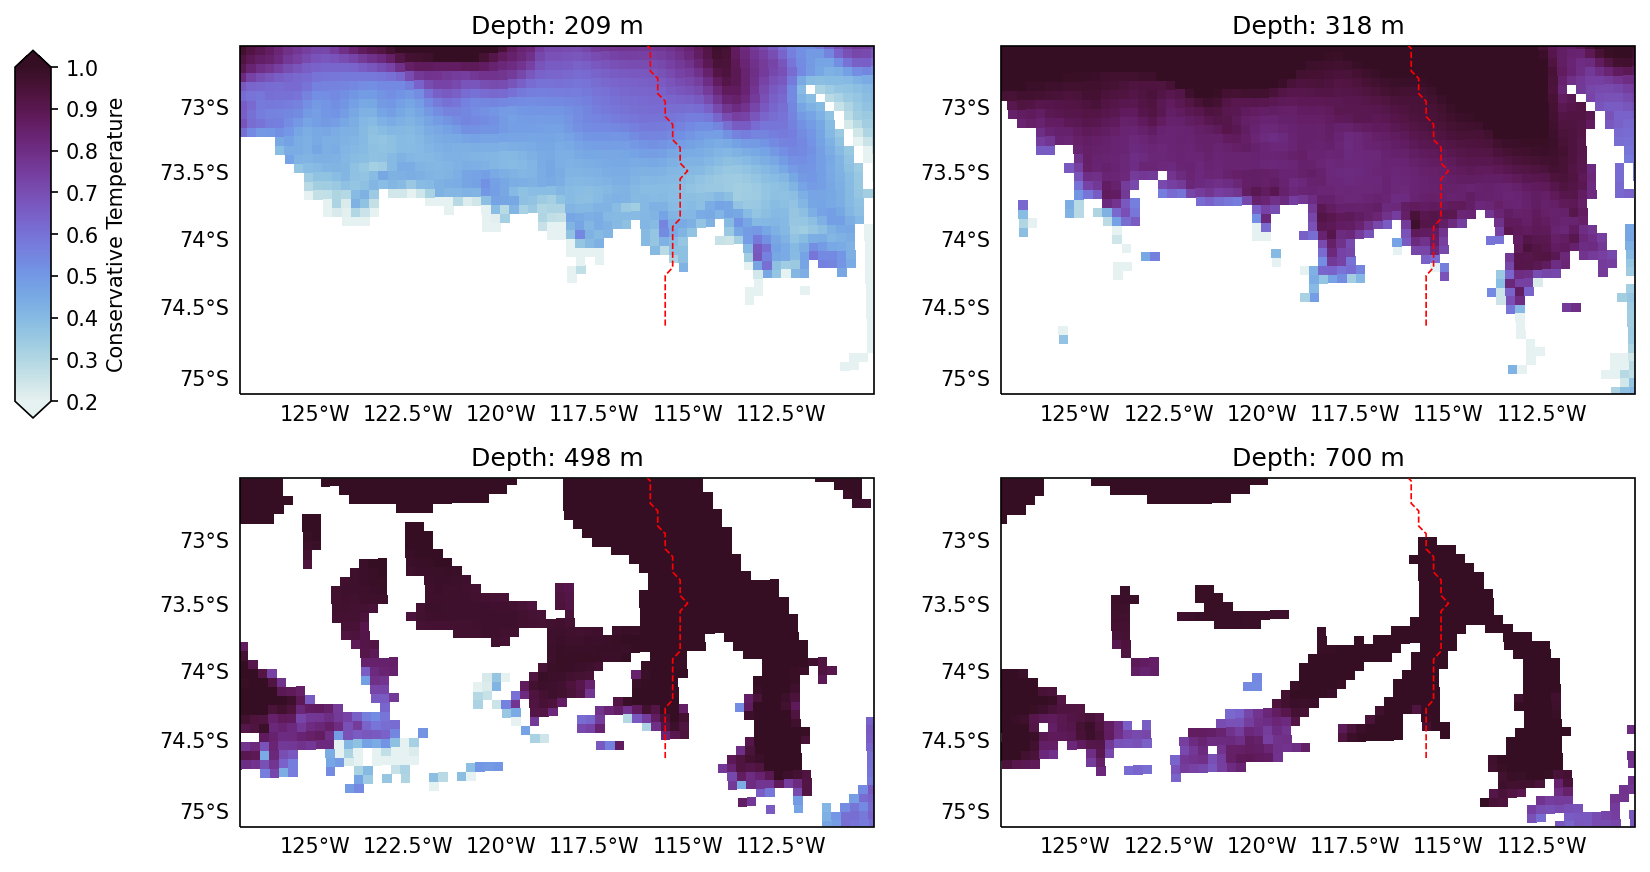

In [70]:
run_folder   = f'{base_dir}output/ERA5_test4'
gridT_files  = glob.glob(f'{run_folder}/*grid_T*')
nemo_ds      = xr.open_mfdataset(gridT_files, engine='netcdf4')
nemo_ds      = nemo_ds.rename({'x_grid_T':'x', 'y_grid_T':'y', 'nav_lon_grid_T':'nav_lon', 'nav_lat_grid_T':'nav_lat', 'deptht':'depth'})
nemo_ds      = nemo_ds.isel(x=slice(520,750), y=slice(160,280))

for time in nemo_ds.time_counter.isel(time_counter=slice(0,1)):
    year  = time.dt.year.values
    month = time.dt.month.values
    day   = time.dt.day.values
    plot_shelf_grid(nemo_ds.sel(time_counter=time), savefig=False, vlim=(0.2,1))

The cold water seems be coming from underneath the Getz ice shelf area and then spreading from there maybe.  Make an animation for this region.

Also, add Shenjie's observational climatology for evaluation

To do today:
- make maps to identify where cold water starts to form
- test runs with new ICs and BCs with and without icebergs